In [1]:
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
import datetime
from dataclasses import dataclass, field
from IPython.display import display, Markdown, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Callable, Dict, List

## Load data

In [20]:
# Go to https://ctcultra.com/result-2024/, lalu save page as HTML (page only)
def read_ctc(filename: str, table_id: str) -> pd.DataFrame:
    with open(filename) as f:
        doc = f.read()
    soup = BeautifulSoup(doc, 'html.parser')
    tabs = soup.find_all(id=table_id)
    assert len(tabs), f"{table_id} not found"
    
    tab = tabs[0]
    tbody = tab.find_all('tbody')[0]
    trs = tbody.find_all('tr')
    
    names = []
    genders = []
    times = []
    
    for tr in trs:
        tds = tr.find_all('td')
        assert len(tds)==9
        
        names.append(tds[1].get_text())
        genders.append(tds[2].get_text())
        times.append(tds[5].get_text())
    
    df = pd.DataFrame({'name': names, 'gender': genders, 'time': times})
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].replace('FEMALE', 'f').replace('MALE', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    
    return df

def read_scorenow(filename: str) -> pd.DataFrame:
    df = pd.read_excel(filename)
    df = df[ df['bib'].notnull() ]
    df = df[ ~df['time'].isin(['DNS', 'DQ', 'Not started', 'Unofficial Winner'])]
    df = df[['name', 'gender', 'time']]
    
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].replace('Female', 'f').replace('Male', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s.lower() not in ['cot', 'dnf', 'dq'] else pd.NaT )
    return df

# Untuk BTR, lihat di result table, lalu copy isi tabel satu per satu per halaman ke OO Calc
def read_btr(filename: str) -> pd.DataFrame:
    return read_scorenow(filename)

# Untuk Mantra, open result page, liat XHR requests, copy jsonnya
def read_mantra(filename: str) -> pd.DataFrame:
    with open(filename) as f:
        doc = json.load(f)
    
    results = doc['result']
    cols = list(results[0].keys())
    data = {col: [] for col in cols}
    for r in results:
        for c in cols:
            data[c].append(r[c])
            
    df = pd.DataFrame(data)
    df = df[['fullname', 'gender', 'age', 'time']]
    df = df.rename(columns={'fullname': 'name'})
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].replace('Female', 'f').replace('Male', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}
    df['age'] = df['age'].fillna(0).astype(int)
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    df = df.reset_index(drop=True)
    return df

# Untuk Bromo Tengger, pakai result excel yg disediakan panitia
def read_bromotengger(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df = df[['fullname', 'gender', 'time']]
    df = df.rename(columns={'fullname': 'name'})
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].replace('FEMALE', 'f').replace('MALE', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    df = df.reset_index(drop=True)
    return df

# Read results in sixrace.id
def read_sixrace(filename: str):
    with open(filename) as f:
        doc = f.read()
    soup = BeautifulSoup(doc, 'html.parser')
    tabs = soup.find_all('table', id='example')
    assert len(tabs), f"table id=example not found"
    
    tab = tabs[0]
    tbody = tab.find_all('tbody')[0]
    trs = tbody.find_all('tr')
    
    names = []
    times = []
    statuses = []
    
    for tr in trs:
        tds = tr.find_all('td')
        assert len(tds)==4
        
        names.append(tds[2].get_text().strip())
        infos = tds[3].get_text().split()
        times.append(infos[0])
        statuses.append(infos[1])
    
    df = pd.DataFrame({'name': names, 'time': times, 'status': statuses})
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    
    df = df[ df['status'] != 'DNS' ].reset_index(drop=True)
    statuses = df['status'].unique()
    assert set(statuses).issubset({'Finished', 'DNF', 'DQ'}), f"Found unknown status: " + str(statuses)
    
    max_time = df['time'].max()
    df.loc[ df['status']=='DNF', 'time'] = pd.NaT
    df = df.reset_index(drop=True)
    return df

# Untuk MSR, go https://sixrace.id/result/view.php?r=r243, save as html page once race cat per file
def read_msr(filename: str):
    return read_sixrace(filename)

# Untuk MMDT, go to https://sixrace.id/result/view.php?r=r247, save has html one race cat per file
def read_mmdt(filename: str):
    return read_sixrace(filename)

# Untuk SLU, open result page, liat XHR requests, copy jsonnya
def read_slu(filename: str) -> pd.DataFrame:
    with open(filename) as f:
        results = json.load(f)
    
    datas = []
    for r in results:
        data = {
            'name': r['value']['name'].strip().title(),
            'gender': r['value']['city'],
            'time': r['value']['time'],
        }
        datas.append(data)
            
    df = pd.DataFrame(datas)
    df['gender'] = df['gender'].replace('Pria', 'm').replace('Wanita', 'f')
    assert set(df['gender'].unique()) == {'f', 'm'}, 'Found ' + str(set(df['gender'].unique()))
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    df = df.reset_index(drop=True)
    return df

# Copy table from ITRA race result, paste to OO Calc
def read_itra(filename: str) -> pd.DataFrame:
    df = pd.read_excel(filename)
    df = df[['name', 'time', 'age', 'gender']]
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].apply(lambda s: s.strip().replace('H', 'm').replace('F', 'f'))
    assert set(df['gender'].unique()) == {'f', 'm'}, 'Found ' + str(set(df['gender'].unique()))
    df['time'] = df['time'].astype(str)
    df['time'] = df['time'].apply(lambda s: s.replace(' AM', '') if s else '')
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    df = df.reset_index(drop=True)
    return df

# Go to https://pickmyrace.id/events/dieng-caldera-race-2024/, lalu save page as HTML (page only)
def read_pickmyrace(filename: str, table_id: str) -> pd.DataFrame:
    with open(filename) as f:
        doc = f.read()
    soup = BeautifulSoup(doc, 'html.parser')
    tabs = soup.find_all(id=table_id)
    assert len(tabs), f"{table_id} not found"
    
    tab = tabs[0]
    tbody = tab.find_all('tbody')[0]
    trs = tbody.find_all('tr')
    
    names = []
    genders = []
    times = []
    
    for tr in trs:
        tds = tr.find_all('td')
        assert len(tds)>=9
        
        names.append(tds[1].get_text().strip().title())
        genders.append(tds[2].get_text().strip())
        times.append(tds[8].get_text().strip())
    
    df = pd.DataFrame({'name': names, 'gender': genders, 'time': times})
    df['name'] = df['name'].apply(lambda s: s.title())
    df['gender'] = df['gender'].replace('FEMALE', 'f').replace('MALE', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}, 'Found ' + str(set(df['gender'].unique()))
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    df.loc[ df['time'] >= pd.Timedelta(hours=99), 'time'] = pd.NaT
    df = df.reset_index(drop=True)
    return df

# Go to https://pickmyrace.id/events/dieng-caldera-race-2024/, lalu save page as HTML (page only)
def read_dcr(filename: str, table_id: str) -> pd.DataFrame:
    return read_pickmyrace(filename, table_id)

# Go to https://bromomarathon.com/past-results, check XHR
def read_bromar(filename: str, category: str) -> pd.DataFrame:
    with open(filename) as f:
        results = json.load(f)
    
    datas = []
    for r in results:
        data = {
            'name': r['full_name'].strip().title(),
            'gender': r['gender'],
            'time': r['finish_time'],
            'category': r['category'],
            'status': r['status'],
            'country': r['nationality'],
        }
        datas.append(data)
            
    df = pd.DataFrame(datas)
    df['gender'] = df['gender'].replace('Female', 'f').replace('Male', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}, 'Found ' + str(set(df['gender'].unique()))
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s else pd.NaT )
    
    df = df[ df['category']==category ]
    df = df[ ~df['status'].isin(['DNS', 'DQF']) ]
    df = df.reset_index(drop=True)
    return df

# Untuk Rinjani100, lihat di result table, lalu copy isi tabel satu per satu per halaman ke OO Calc
def read_rinjani100(filename: str) -> pd.DataFrame:
    df = pd.read_excel(filename)
    df = df[ df['bib'].notnull() ]
    df = df[ ~df['time'].isin(['DNS', 'DQ'])]
    df = df[['name', 'gender', 'time']]
    
    df['name'] = df['name'].apply(lambda s: s.strip().title())
    df['gender'] = df['gender'].replace('Female', 'f').replace('Male', 'm')
    assert set(df['gender'].unique()) == {'f', 'm'}, 'Found ' + str(set(df['gender'].unique()))
    df['time'] = df['time'].apply(lambda s: pd.Timedelta(s) if s.lower() not in ['cot', 'dnf', 'dq'] else pd.NaT )
    df = df.reset_index(drop=True)
    return df

# Go to https://pickmyrace.id/preliminary-bali-ultra-trail-2024/, lalu save page as HTML (page only)
def read_but(filename: str, table_id: str) -> pd.DataFrame:
    return read_pickmyrace(filename, table_id)

# Jabar ultra: https://jabarultra.com/race-result-2024/, and save table to excel
def read_jbu(filename: str) -> pd.DataFrame:
    return read_scorenow(filename)

## Daftar Race

In [22]:
%%time

@dataclass
class Race:
    title: str
    distance: float
    eg: float
    date: str
    load_fn: Callable
    quals: List[str] = field(default_factory=list)  # ITRA and UTMB qualifications
    dist_name: str = None    # name if distance is same for the same race
    peaks: List[str] = None  # Info about peaks, views
    df: pd.DataFrame = None  # DataFrame
    dnf: int = None          # Number of DNFs
    times: pd.Series = None  # Finisher time
    mean: float = None       # in hours
    median: float = None     # in hours


BRO = "Bromo Mar"
BTG = "Bromo Tgger"
BTR = "BTR"
BUT = "BUT"
CTC = "CTC"
DCR = "Dieng Caldera"
JBU = "JBU"
MAN = "Mantra"
MMD = 'MMDT'
MSR = "MSR"
MST = "MesaStila100"
RIN = 'Rinjani100'
SLU = "SLU"
SSC = "SSC"
VTM = 'V. Telomoyo'

ITRA0 = 'ITRA 0'
ITRA1 = 'ITRA 1'
ITRA2 = 'ITRA 2'
ITRA3 = 'ITRA 3'
ITRA4 = 'ITRA 4'
ITRA5 = 'ITRA 5'
ITRA6 = 'ITRA 6'
UT20K =  'UTMB 20K'
UT50K =  'UTMB 50K'
UT100K = 'UTMB 100K'
UT100M = 'UTMB 100M'

races = [
    Race(BRO, 5, 241, '2023-09-03', lambda:read_bromar('data/2023/bromar.json', '5K')),
    Race(MMD, 5, 700, '2024-08-04', lambda:read_mmdt('data/2024/mmdt-5k.html'), [ITRA0]),
    Race(SLU, 7, 400, '2023-12-03', lambda:read_slu('data/2023/slu7k.json')),
    Race(VTM, 7, 810, '2023-10-01', lambda:read_msr('data/2023/telomoyo7k.html')),
    Race(BRO, 10, 426, '2023-09-03', lambda:read_bromar('data/2023/bromar.json', '10K')),
    Race(MMD, 10, 1320, '2024-08-04', lambda:read_mmdt('data/2024/mmdt-10k.html'), [ITRA0, UT20K], peaks=['Merbabu']),
    Race(BTG, 11, 480, '2024-07-28', lambda:read_bromotengger('data/2024/bromo11k.csv')),
    Race(BUT, 12, 330, '2024-08-03', lambda:read_but('data/2024/but.html', 'table_1')),
    Race(MAN, 10, 620, '2024-07-07', lambda:read_mantra('data/2024/mantra116-10k.json'), [ITRA0, ]),
    Race(MSR, 10, 810, '2024-04-28', lambda:read_msr('data/2024/msr10k.html'), [ITRA0]),
    Race(DCR, 10, 495, '2024-06-09', lambda:read_dcr('data/2024/dcr.html', 'table_1'), [ITRA0]),
    Race(CTC, 15, 300, '2024-02-25', lambda:read_ctc('data/2024/ctc.html', 'table_1'), [ITRA0]),
    Race(BTR, 15, 973, '2024-05-12', lambda:read_btr('data/2024/btr15k.xlsx'), [UT20K], peaks=['Batur']),
    Race(SLU, 15, 1200, '2023-12-03', lambda:read_slu('data/2023/slu15k.json'), [ITRA0, ]),
    Race(MAN, 17, 1000, '2024-07-07', lambda:read_mantra('data/2024/mantra116-17k.json'), [ITRA1, UT20K]),
    Race(MSR, 20, 1830, '2024-04-28', lambda:read_msr('data/2024/msr20k.html'), [ITRA0, UT20K]),
    Race(SSC, 20, 1963, '2024-05-05', lambda:read_itra('data/2024/ssc-sumbing.xlsx'), [ITRA1], dist_name='Sumbing', peaks=['Sumbing']),
    Race(SSC, 20, 2076, '2024-05-05', lambda:read_itra('data/2024/ssc-sindoro.xlsx'), [ITRA1], dist_name='Sindoro', peaks=['Sindoro']),
    Race(MMD, 20, 2940, '2024-08-04', lambda:read_mmdt('data/2024/mmdt-20k.html'), [ITRA2, UT20K], peaks=['Merbabu', 'Merbabu(2)']),
    Race(BRO, 21, 977, '2023-09-03', lambda:read_bromar('data/2023/bromar.json', '21K'), peaks=['Bromo']),
    Race(BTG, 21, 1000, '2024-07-28', lambda:read_bromotengger('data/2024/bromo21k.csv'), [ITRA1, UT20K], peaks=['Bromo']),
    Race(MST, 21, 1230, '2023-10-08', lambda:read_itra('data/2023/mesastila100-21k.xlsx')),
    Race(DCR, 21, 1185, '2024-06-09', lambda:read_dcr('data/2024/dcr.html', 'table_2'), [ITRA1, UT20K]),
    Race(JBU, 22, 2500, '2024-06-09', lambda:read_jbu('data/2024/jabarultra-22k.xlsx'), [ITRA2, UT20K], peaks=['Ciremai']),
    Race(BUT, 25, 1650, '2024-08-03', lambda:read_but('data/2024/but.html', 'table_2'), [ITRA2, UT20K]),
    Race(RIN, 27, 1847, '2024-05-26', lambda:read_rinjani100('data/2024/rinjani100-27k.xlsx'), [ITRA1, UT20K]),
    Race(VTM, 27, 1420, '2023-10-01', lambda:read_msr('data/2023/telomoyo27k.html'), [ITRA1, UT20K]),
    Race(CTC, 30, 1040, '2024-02-25', lambda:read_ctc('data/2024/ctc.html', 'table_2'), [ITRA0, UT20K]),
    Race(SLU, 30, 1800, '2023-12-03', lambda:read_slu('data/2023/slu30k.json'), [ITRA1, UT20K]),
    Race(BTR, 30, 1340, '2024-05-12', lambda:read_btr('data/2024/btr30k.xlsx'), [ITRA1, UT20K], peaks='Batur'),
    Race(MAN, 34, 3050, '2024-07-07', lambda:read_mantra('data/2024/mantra116-34k.json'), [ITRA2, UT50K], dist_name='Arjuno', peaks=['Arjuno']),
    Race(SSC, 35, 4046, '2024-05-05', lambda:read_itra('data/2024/ssc-40k.xlsx'), [ITRA3], peaks='Sindoro, Sumbing'),
    Race(RIN, 36, 3179, '2024-05-26', lambda:read_rinjani100('data/2024/rinjani100-36k.xlsx'), [ITRA2, UT50K]),
    Race(MAN, 38, 2750, '2024-07-07', lambda:read_mantra('data/2024/mantra116-38k.json'), [ITRA2, UT50K], dist_name='Welirang', peaks=['Welirang']),
    Race(MSR, 40, 4290, '2024-04-28', lambda:read_msr('data/2024/msr40k.html'), [ITRA3, UT50K]),
    Race(BRO, 42, 1930, '2023-09-03', lambda:read_bromar('data/2023/bromar.json', '42K'), peaks=['Bromo']),
    Race(DCR, 42, 2630, '2024-06-09', lambda:read_dcr('data/2024/dcr.html', 'table_3'), [ITRA2, UT50K]),
    Race(CTC, 50, 1620, '2024-02-25', lambda:read_ctc('data/2024/ctc.html', 'table_3'), [ITRA2, UT50K]),
    Race(BUT, 50, 2730, '2024-08-03', lambda:read_but('data/2024/but.html', 'table_3'), [ITRA3, UT50K]),
    Race(SLU, 50, 3800, '2023-12-03', lambda:read_slu('data/2023/slu50k.json'), [ITRA3, UT50K]),
    Race(MSR, 50, 5970, '2024-04-28', lambda:read_msr('data/2024/msr50k.html'), [ITRA3, UT100K]),
    Race(JBU, 55, 6010, '2024-06-09', lambda:read_jbu('data/2024/jabarultra-55k.xlsx'), [ITRA3, UT100K]),
    Race(BTR, 55, 3778, '2024-05-12', lambda:read_btr('data/2024/btr55k.xlsx'), [ITRA3, UT50K], peaks=['Batur', 'Abang']),
    Race(RIN, 60, 5493, '2024-05-26', lambda:read_rinjani100('data/2024/rinjani100-60k.xlsx'), [ITRA4, UT100K]),
    Race(MAN, 68, 5000, '2024-07-07', lambda:read_mantra('data/2024/mantra116-68k.json'), [ITRA4, UT100K], peaks=['Arjuno', 'Welirang']),
    Race(DCR, 75, 4850, '2024-06-09', lambda:read_dcr('data/2024/dcr.html', 'table_4'), [ITRA4, UT100K]),
    Race(CTC, 80, 2550, '2024-02-25', lambda:read_ctc('data/2024/ctc.html', 'table_4'), [ITRA3, UT100K]),
    Race(BUT, 80, 4400, '2024-08-03', lambda:read_but('data/2024/but.html', 'table_4'), [ITRA4, UT100K]),
    Race(SLU, 80, 5400, '2023-12-03', lambda:read_slu('data/2023/slu80k.json'), [ITRA4, UT100K]),
    Race(BTR, 85, 5250, '2024-05-12', lambda:read_btr('data/2024/btr85k.xlsx'), [ITRA4, UT100K]),
    Race(RIN, 100, 9194, '2024-05-26', lambda:read_rinjani100('data/2024/rinjani100-100k.xlsx'), [ITRA6, UT100M]),
    Race(MAN, 116, 7400, '2024-07-07', lambda:read_mantra('data/2024/mantra116-116k.json'), [ITRA5, UT100M], peaks=['Arjuno', 'Welirang']),
    Race(RIN, 162, 13646, '2024-05-26', lambda:read_rinjani100('data/2024/rinjani100-162k.xlsx'), [ITRA6, UT100M]),
]

def load_races():
    global races
    for i, race in enumerate(races):
        print(f'Reading race data {i+1}/{len(races)}..   \r', end='')
        race.df = race.load_fn()
        race.dnf = sum(pd.isnull(race.df['time']))
        race.times = race.df.loc[ race.df['time'].notnull(), 'time'].dt.total_seconds() / 3600
        race.mean = race.times.mean()
        race.median = race.times.median()
        
    print('\nDone')
    
load_races()

Reading race data 53/53..   
Done
CPU times: user 11.9 s, sys: 94.8 ms, total: 12 s
Wall time: 12 s


## Plot Distribusi

In [23]:
def plot_distribution(race: Race, names: List[str] = [], ax=None):
    bins = 30

    dist_name = f'({race.dist_name}) ' if race.dist_name else ''
    title = f'{race.title} {race.distance:.0f}K {race.eg:.0f}m {dist_name}({race.date})'
    df = race.df
    times = df.loc[ df['time'].notnull(), 'time'].dt.total_seconds() / 3600
    
    if ax:
        ax.hist(times, bins=bins, alpha=0.6)
        ax.grid()
        show = False
    else:
        ax = times.hist(bins=bins, alpha=0.6, figsize=(8,5))
        show = True
    ax.set_xlabel('Finished Time (Hour)')
    ax.set_ylabel('Number of runners')
    
    title = title + f' finishers: {len(times)}'
    if race.dnf:
        title += f', dnf: {race.dnf} ({race.dnf/(race.dnf+len(times)):.0%})'
        
    ax.set_title(title)
    ax.axvline(x=times.mean(), linestyle=':',
              color='k', alpha=1, zorder=100, label='mean')
    ax.axvline(x=times.median(), linestyle='--',
              color='k', alpha=1, zorder=100, label='median')
    
    if race.quals:
        quals = ', '.join(race.quals)
        right = ax.get_xlim()[1]
        top = ax.get_ylim()[1]
        ax.text(right, top*0.99, quals,
                horizontalalignment='right',
                verticalalignment='top', fontweight='book')
    
    icolor = 0
    for name in names:
        found = df[ df['name'].str.contains(name) ]
        if not len(found):
            continue

        a = found.iloc[0]
        t = a['time'].total_seconds() / 3600
        ax.axvline(x=t, color=f'C{1+icolor}', alpha=1, zorder=10, label=name)
        icolor += 1
            
    
    ax.legend(loc='upper left')
    if show:
        plt.show()
        
def plot_age_distribution(ages: pd.Series):
    ages = ages[(ages>10) & (ages<100)]
    ax = ages.hist(bins=20, figsize=(8,5))
    ax.set_title('Age Distribution' + f' (finishers: {len(ages)})')


## Distribusi Finisher

CPU times: user 12.1 s, sys: 2.22 s, total: 14.3 s
Wall time: 9.46 s


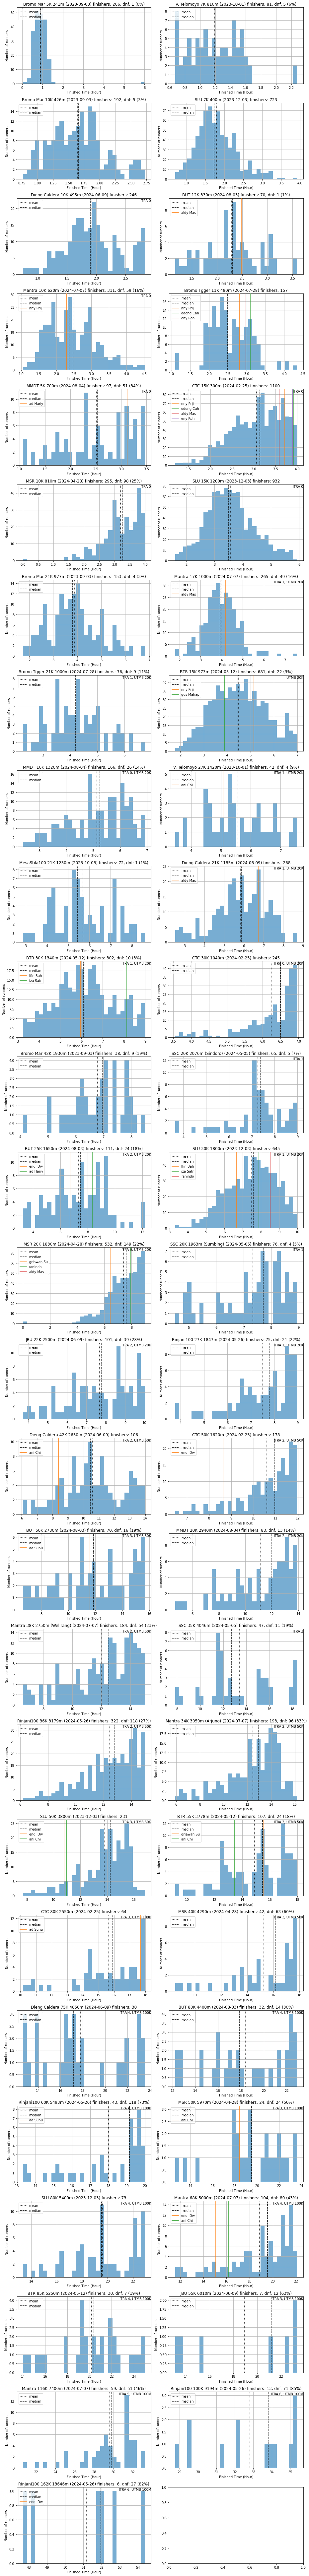

In [24]:
%%time
list_nama = ['nny Prij', 'odong Cah', 'lfin Bah', 'griawan Su', 'iza Satr',
             'ranindo', 'aldy Mas', 'eny Roh', 'gus Mahap',
             'endi Dw', 'ad Suhu', 'ad Hariy',
             'ani Chi']

def distribusi_finisher():
    global races
    races = sorted(races, key=lambda r: r.median)
    ncols = 2
    nrows = (len(races)+ncols-1)//ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6.5, nrows*4))
    r,c=0,0
    for i in range(len(races)):
        race = races[i]
        plot_distribution(race, list_nama, ax=axs[r][c])
        c+=1
        if c==ncols:
            r+=1
            c=0

    fig.tight_layout()
    #plt.show()
    plt.savefig('stat.png')

distribusi_finisher()